In [1]:
import os
import sqlite3
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
DB_PATH = os.environ["DB_PATH"]

def db_ingest(csv_dir: str, table_name: str):
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_csv(csv_dir)
    df.to_sql(name=table_name, con=conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()

In [ ]:
ss = "2018_2019"
db_ingest(f"./etl/staging_data/possession_{ss}_cleaned.csv", f"possession_{ss}_standard")
db_ingest(f"./etl/staging_data/gca_{ss}_cleaned.csv", f"gca_{ss}_standard")
db_ingest(f"./etl/staging_data/{ss}_cleaned.csv", f"{ss}_standard")
conn = sqlite3.connect(DB_PATH)


In [80]:
query = '''
SELECT *
FROM "2018_2019_standard" AS st17
LEFT JOIN "possession_2018_2019_standard" AS ps17
  ON st17.Player = ps17.Player AND st17.Squad = ps17.Squad AND st17.Nation = ps17.Nation
LEFT JOIN "gca_2018_2019_standard" AS gca17
  ON st17.Player = gca17.Player AND st17.Squad = gca17.Squad AND st17.Nation = gca17.Nation
'''
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(query, conn)


In [81]:
df = df.loc[:,~df.columns.duplicated()]

In [82]:
df = df[
    (
        (df["Succ"] >= df["Succ"].max() * 0.65) | (df["SCA"] >= df["SCA"].max() * 0.65)
    )
]

In [83]:
df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt',
       'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR',
       'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK', 'xG_90', 'xAG_90',
       'xG+xAG', 'npxG_90', 'npxG+xAG_90', 'Matches', 'Touches', 'Def Pen',
       'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att', 'Succ',
       'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', '1/3', 'CPA',
       'Mis', 'Dis', 'Rec', 'SCA', 'SCA90', 'PassLive', 'PassDead', 'TO', 'Sh',
       'Fld', 'Def', 'GCA', 'GCA90', 'PassLive_90', 'PassDead_90', 'TO_90',
       'Sh_90', 'Fld_90', 'Def_90'],
      dtype='object')

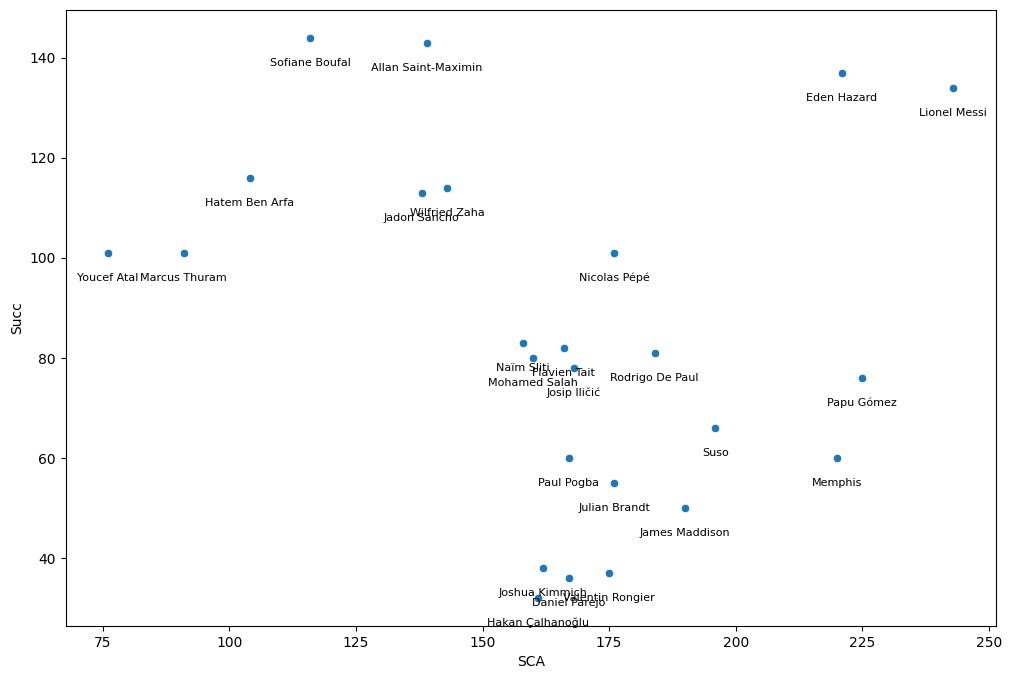

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df, x='SCA', y='Succ')
for _, row in df.iterrows():
    ax.text(x=row['SCA'], y=row['Succ'] -5, s=row['Player'], fontsize=8, horizontalalignment='center', verticalalignment='center')

In [102]:
cursor = conn.cursor()
cursor.execute(
    "PRAGMA table_info('2017_2018_standard')"
)

In [103]:
rows = cursor.fetchall()


In [104]:
rows

[(0, 'Rk', 'INTEGER', 0, None, 0),
 (1, 'Player', 'TEXT', 0, None, 0),
 (2, 'Nation', 'TEXT', 0, None, 0),
 (3, 'Pos', 'TEXT', 0, None, 0),
 (4, 'Squad', 'TEXT', 0, None, 0),
 (5, 'Comp', 'TEXT', 0, None, 0),
 (6, 'Age', 'REAL', 0, None, 0),
 (7, 'Born', 'REAL', 0, None, 0),
 (8, 'MP', 'INTEGER', 0, None, 0),
 (9, 'Starts', 'INTEGER', 0, None, 0),
 (10, 'Min', 'INTEGER', 0, None, 0),
 (11, '90s', 'REAL', 0, None, 0),
 (12, 'Gls', 'INTEGER', 0, None, 0),
 (13, 'Ast', 'INTEGER', 0, None, 0),
 (14, 'G+A', 'INTEGER', 0, None, 0),
 (15, 'G-PK', 'INTEGER', 0, None, 0),
 (16, 'PK', 'INTEGER', 0, None, 0),
 (17, 'PKatt', 'INTEGER', 0, None, 0),
 (18, 'CrdY', 'INTEGER', 0, None, 0),
 (19, 'CrdR', 'INTEGER', 0, None, 0),
 (20, 'xG', 'REAL', 0, None, 0),
 (21, 'npxG', 'REAL', 0, None, 0),
 (22, 'xAG', 'REAL', 0, None, 0),
 (23, 'npxG+xAG', 'REAL', 0, None, 0),
 (24, 'PrgC', 'REAL', 0, None, 0),
 (25, 'PrgP', 'REAL', 0, None, 0),
 (26, 'PrgR', 'REAL', 0, None, 0),
 (27, 'Gls_90', 'REAL', 0, None, 

In [112]:
df["G+A"].dtype

dtype('int64')

In [116]:
list(df.columns)

['Rk',
 'Player',
 'Nation',
 'Pos',
 'Squad',
 'Comp',
 'Age',
 'Born',
 'MP',
 'Starts',
 'Min',
 '90s',
 'Gls',
 'Ast',
 'G+A',
 'G-PK',
 'PK',
 'PKatt',
 'CrdY',
 'CrdR',
 'xG',
 'npxG',
 'xAG',
 'npxG+xAG',
 'PrgC',
 'PrgP',
 'PrgR',
 'Gls_90',
 'Ast_90',
 'G+A_90',
 'G-PK_90',
 'G+A-PK',
 'xG_90',
 'xAG_90',
 'xG+xAG',
 'npxG_90',
 'npxG+xAG_90',
 'Matches',
 'Touches',
 'Def Pen',
 'Def 3rd',
 'Mid 3rd',
 'Att 3rd',
 'Att Pen',
 'Live',
 'Att',
 'Succ',
 'Succ%',
 'Tkld',
 'Tkld%',
 'Carries',
 'TotDist',
 'PrgDist',
 '1/3',
 'CPA',
 'Mis',
 'Dis',
 'Rec',
 'SCA',
 'SCA90',
 'PassLive',
 'PassDead',
 'TO',
 'Sh',
 'Fld',
 'Def',
 'GCA',
 'GCA90',
 'PassLive_90',
 'PassDead_90',
 'TO_90',
 'Sh_90',
 'Fld_90',
 'Def_90']

In [135]:
cols = []
for col in list(df.columns):
    if str(df[col].dtype)=="float64" or str(df[col].dtype)=="int64":
        cols.append(col)

In [142]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X = ss.fit_transform(df[cols].values)

In [165]:
list(scaled_X)

[array([-1.7347112 , -0.80837896,  0.9092254 , -2.07301659, -1.46048905,
        -1.39968084, -1.40922892, -0.52439328, -1.88711594, -1.16363874,
        -0.32956308, -0.73979544, -0.53550416,  1.54161478, -0.52489066,
        -0.85964682, -0.78655327, -1.75382768, -1.34770256, -0.09080267,
        -1.36638174,  0.30503734, -0.34030525, -1.90665887, -1.0409198 ,
        -0.11689667, -0.92238459, -0.73348232, -1.65276992, -1.21084634,
        -0.64372989, -1.15140158, -0.38563925,  1.68600122,  1.09614977,
        -0.32175136, -1.01534307, -0.51234971, -0.38285946,  0.99662456,
         0.47845085, -1.87412404,  1.53516649,  1.87412404, -0.94493545,
        -0.61092479, -0.138543  , -0.30688109,  0.24767613,  0.09821327,
        -1.23450831, -0.96308957, -2.23154239, -1.93776591, -2.0281327 ,
        -1.03349014, -0.33031771, -1.46199309,  0.02966954,  0.10752067,
        -1.7888009 , -1.73492939, -1.68004374, -1.21591458, -0.85796918,
        -0.2547719 , -0.94245293, -0.20412415]),
 a

In [ ]:
query = "SELECT * FROM \"2017_2018_standard\" WHERE Player = ?"
cursor.execute(query, ('Lionel Messi',))
rel = cursor.fetchall()
print(rel[0])


(1654, 'Lionel Messi', 'ar ARG', 'FW', 'Barcelona', 'es La Liga', 30.0, 1987.0, 36, 32, 3000, 33.3, 34, 12, 46, 32, 2, 4, 3, 0, 27.1, 24.0, 13.9, 37.9, 211.0, 333.0, 263.0, 1.02, 0.36, 1.38, 0.96, 1.32, 0.81, 0.42, 1.23, 0.72, 1.14, 'Matches')


In [168]:
list(rel[0])

[1654,
 'Lionel Messi',
 'ar ARG',
 'FW',
 'Barcelona',
 'es La Liga',
 30.0,
 1987.0,
 36,
 32,
 3000,
 33.3,
 34,
 12,
 46,
 32,
 2,
 4,
 3,
 0,
 27.1,
 24.0,
 13.9,
 37.9,
 211.0,
 333.0,
 263.0,
 1.02,
 0.36,
 1.38,
 0.96,
 1.32,
 0.81,
 0.42,
 1.23,
 0.72,
 1.14,
 'Matches']

In [ ]:
df.